# SCARF Notebook
Based on: https://github.com/clabrugere/pytorch-scarf.git

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# If you need to adjust the path below, please adjust the path in the 'Data_Preperation_...' file accordingly
%cd /content/drive/MyDrive/Energy_Prediction/models/self_supervised/scarf

/content/drive/MyDrive/Energy_Prediction/models/self_supervised/scarf


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
from torch.optim import Adam
from torch.utils.data import DataLoader
sys.path.append("../")

from scarf.loss import NTXent
from scarf.model import SCARF
from scarf.dataset import SCARFDataset
from example.utils import get_device, dataset_embeddings, fix_seed, train_epoch
from Data_Preperation_Scarf import X_pretrain, X_train, y_train, X_test, y_test

seed = 1234
fix_seed(seed)

# Data

In [ ]:
pretrain_ds = SCARFDataset(X_pretrain, None)
train_ds = SCARFDataset(X_train, y_train)
test_ds = SCARFDataset(X_test, y_test)

print(f"Pretrain set: {pretrain_ds.shape}")
print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")

Pretrain set: (5110, 51)
Train set: (1620, 51)
Test set: (175, 51)


# Training

epoch 10/500 - loss: 0.0123
epoch 20/500 - loss: 0.0122
epoch 30/500 - loss: 0.0122
epoch 40/500 - loss: 0.0122
epoch 50/500 - loss: 0.0122
epoch 60/500 - loss: 0.0121
epoch 70/500 - loss: 0.0121
epoch 80/500 - loss: 0.0121
epoch 90/500 - loss: 0.0121
epoch 100/500 - loss: 0.0121
epoch 110/500 - loss: 0.0121
epoch 120/500 - loss: 0.0121
epoch 130/500 - loss: 0.0120
epoch 140/500 - loss: 0.0120
epoch 150/500 - loss: 0.0120
epoch 160/500 - loss: 0.0120
epoch 170/500 - loss: 0.0120
epoch 180/500 - loss: 0.0120
epoch 190/500 - loss: 0.0120
epoch 200/500 - loss: 0.0120
epoch 210/500 - loss: 0.0120
epoch 220/500 - loss: 0.0120
epoch 230/500 - loss: 0.0120
epoch 240/500 - loss: 0.0120
epoch 250/500 - loss: 0.0120
epoch 260/500 - loss: 0.0120
epoch 270/500 - loss: 0.0120
epoch 280/500 - loss: 0.0120
epoch 290/500 - loss: 0.0120
epoch 300/500 - loss: 0.0120
epoch 310/500 - loss: 0.0120
epoch 320/500 - loss: 0.0120
epoch 330/500 - loss: 0.0120
epoch 340/500 - loss: 0.0120
epoch 350/500 - loss: 0

Text(0, 0.5, 'loss')

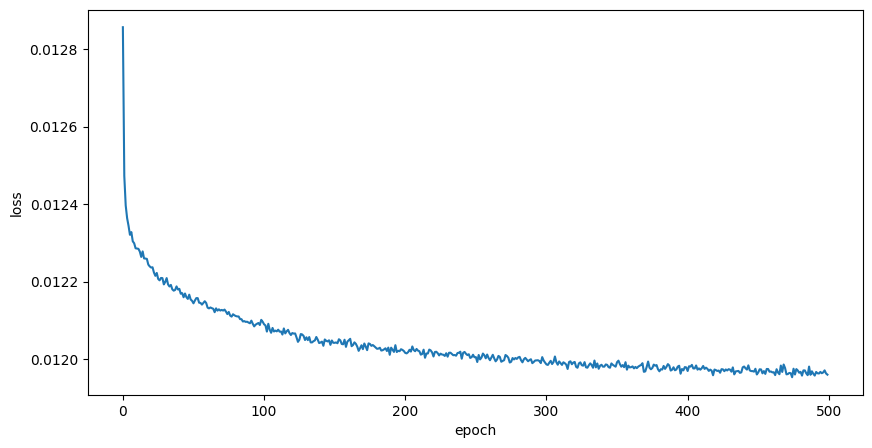

In [ ]:
batch_size = 512
epochs = 500
device = get_device()

pretrain_loader = DataLoader(pretrain_ds, batch_size=batch_size, shuffle=True)
model = SCARF(
    input_dim=train_ds.shape[1],
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    dim_hidden_encoder=512,
    num_hidden_encoder=3,
    dim_hidden_head=256,
    num_hidden_head=2,
    corruption_rate=0.6,
    dropout=0.1,
).to(device)

optimizer = Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
ntxent_loss = NTXent()

loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, pretrain_loader, optimizer, device)
    loss_history.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}")

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

# Evaluate embeddings

In [ ]:
labeled_train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
labeled_test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

train_embeddings = dataset_embeddings(model, labeled_train_loader, device)
test_embeddings = dataset_embeddings(model, labeled_test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1620, 512)
(175, 512)


# Without self-supervised embeddings

              precision    recall  f1-score   support

         2.0       0.98      1.00      0.99        45
         3.0       0.35      0.50      0.41        12
         4.0       0.55      0.60      0.57        20
         5.0       0.67      0.62      0.64        13
         6.0       0.90      0.67      0.77        27
         7.0       0.39      0.44      0.41        16
         8.0       0.56      0.36      0.43        14
         9.0       0.40      0.40      0.40        15
        10.0       0.81      1.00      0.90        13

    accuracy                           0.69       175
   macro avg       0.62      0.62      0.61       175
weighted avg       0.70      0.69      0.69       175



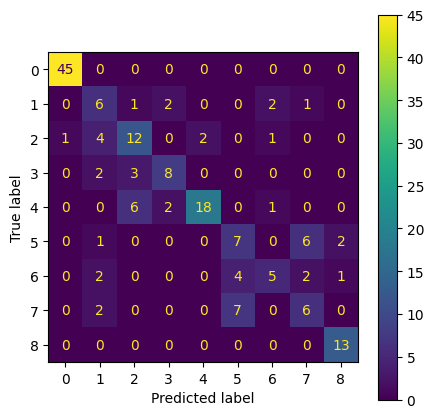

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

vanilla_predictions = clf.predict(X_test)

print(classification_report(y_test, vanilla_predictions))
cm = confusion_matrix(y_test, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

# Self-supervised embeddings part

In [ ]:
clf.fit(train_embeddings, y_train)

vanilla_predictions = clf.predict(test_embeddings)

report = classification_report(y_test, vanilla_predictions)
print(report)

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00        45
         3.0       0.79      0.92      0.85        12
         4.0       1.00      0.90      0.95        20
         5.0       0.81      1.00      0.90        13
         6.0       1.00      0.93      0.96        27
         7.0       0.84      1.00      0.91        16
         8.0       1.00      0.64      0.78        14
         9.0       0.93      0.93      0.93        15
        10.0       0.86      0.92      0.89        13

    accuracy                           0.93       175
   macro avg       0.91      0.92      0.91       175
weighted avg       0.94      0.93      0.93       175



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


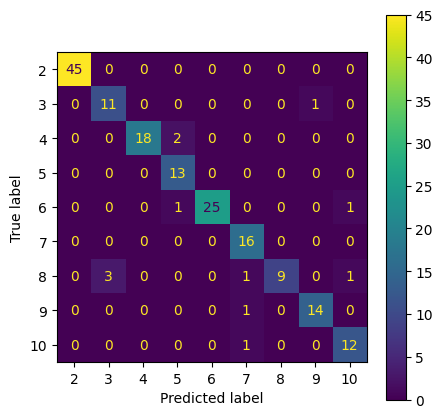

In [ ]:
cm = confusion_matrix(y_test, vanilla_predictions)

class_accuracies = {i: [] for i in range(2, 11)}
for j in range(2, 11):
  idx = j - 2
  class_accuracy = cm[idx, idx] / np.sum(cm[idx, :])
  class_accuracies[j].append(class_accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(2, 11))
accuracy = accuracy_score(y_test, vanilla_predictions)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

# Visualzie using t-sne

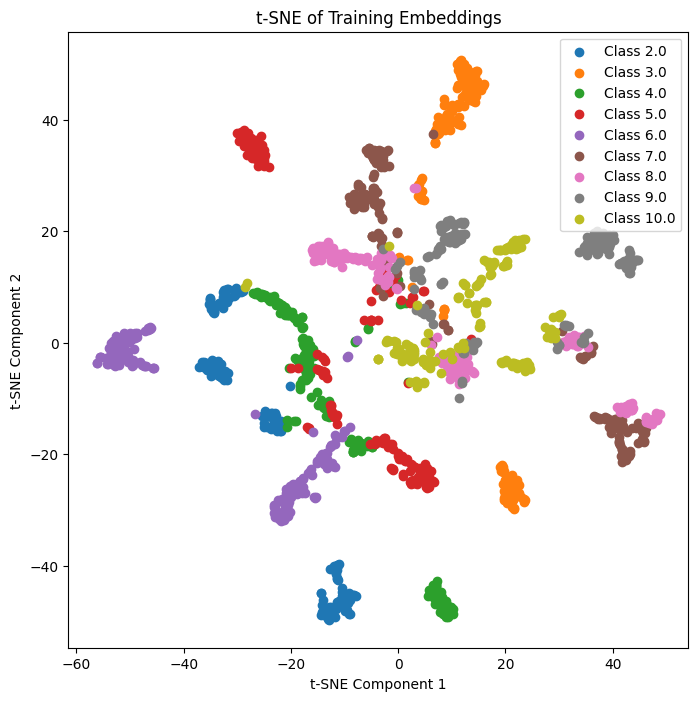

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(train_embeddings)

fig, ax = plt.subplots(figsize=(8, 8))
for label in np.unique(y_train):
    mask = y_train == label
    ax.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], label=f"Class {label}")

ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_title("t-SNE of Training Embeddings")
plt.legend()
plt.show()